In [1]:
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import sf_quant.data as sfd
import sf_quant.optimizer as sfo
import sf_quant.performance as sfp
from tqdm import tqdm
import datetime as dt

/home/kylecm11/silver_fund/orthogonal-alphas/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-10-02 19:15:13,473	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
alpha_data = pl.read_parquet("../signal_weights/signal_data.parquet").with_columns(pl.col('return').shift(-1).over('barrid').alias('fwd_return'))

alpha_data

date,barrid,ticker,price,return,specific_return,specific_risk,historical_beta,predicted_beta,market_cap,daily_volume,bid_ask_spread,log_return,momentum,meanrev,bab,momentum_z,meanrev_z,bab_z,momentum_alpha,meanrev_alpha,bab_alpha,fwd_return
date,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.001595,-0.00788,0.550569,0.328385,0.34349,6.006157e8,121693.0,0.01,-0.001596,null,null,-0.34349,null,null,2.149267,null,null,0.059166,0.009585
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.009585,0.00365,0.55028,0.334989,0.353329,6.0865392e8,131728.0,0.01,0.009539,null,null,-0.353329,null,null,2.111728,null,null,0.058102,-0.001582
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.001582,-0.00731,0.548074,0.330713,0.363624,6.0769086e8,43252.0,0.01,-0.001583,null,null,-0.363624,null,null,2.086144,null,null,0.057168,0.022187
2013-08-05,"""USA06Z1""","""MDXG""",6.45,0.022187,0.01936,0.547667,0.324494,0.356596,6.211737e8,70944.0,0.02,0.021944,null,null,-0.356596,null,null,2.098288,null,null,0.057458,-0.024806
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-0.024806,-0.00528,0.546922,0.366323,0.399196,6.0576474e8,77085.0,0.01,-0.025119,null,null,-0.399196,null,null,2.001238,null,null,0.054726,-0.081081
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-09-09,"""USBRKA2""","""GLIBA""",36.225,-0.004261,0.01121,0.208427,0.236481,0.302514,1.3226e8,31025.0,0.11,-0.00427,null,-0.007341,-0.302514,null,0.37369,2.013268,null,0.003894,0.020981,0.000414
2025-09-10,"""USBRKA2""","""GLIBA""",36.24,0.000414,0.02305,0.209547,0.252015,0.29845,1.3231e8,6298.0,0.21,0.000414,null,-0.020066,-0.29845,null,0.247624,2.007619,null,0.002594,0.021035,0.022351
2025-09-11,"""USBRKA2""","""GLIBA""",37.05,0.022351,0.00213,0.214807,0.256752,0.31384,1.3527e8,26857.0,0.25,0.022105,null,-0.065239,-0.31384,null,0.07841,1.987568,null,0.000842,0.021347,-0.023752


In [3]:
weights_data = pl.read_parquet("../signal_weights/weights/updated_weights_pivot.parquet")

weights_data

date,barrid,bab_weight,meanrev_weight,momentum_weight
date,str,f64,f64,f64
1995-06-30,"""USAA191""",-1.0844e-20,null,null
1995-06-30,"""USAA1W1""",-9.1201e-22,null,null
1995-06-30,"""USAA1Y1""",-4.8273e-21,null,null
1995-06-30,"""USAA2L1""",-4.2673e-21,null,null
1995-06-30,"""USAA311""",-9.2198e-21,null,null
…,…,…,…,…
2025-09-15,"""USBQZR1""",-6.9890e-22,-1.3553e-20,null
2025-09-15,"""USBRGT1""",-3.7165e-21,-3.4045e-19,null
2025-09-15,"""USBRH21""",-2.6956e-21,-9.9263e-20,null


In [4]:
big_data = alpha_data.join(weights_data, on=["date", "barrid"], how="inner").select(['date', 'barrid', 'return', 'fwd_return', 'predicted_beta', 'momentum_alpha', 'meanrev_alpha', 'bab_alpha', 'momentum_weight', 'meanrev_weight', 'bab_weight'])

big_data

date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-06-30,"""USAA191""",0.051471,-0.013986,0.823795,null,null,0.003645,null,null,-1.0844e-20
1995-06-30,"""USAA1W1""",0.057971,0.0,1.105022,null,null,-0.010093,null,null,-9.1201e-22
1995-06-30,"""USAA1Y1""",0.028777,-0.017483,1.636947,null,null,-0.027408,null,null,-4.8273e-21
1995-06-30,"""USAA2L1""",0.036585,0.002941,0.725292,null,null,0.010805,null,null,-4.2673e-21
1995-06-30,"""USAA311""",0.020134,-0.006579,0.798643,null,null,0.005402,null,null,-9.2198e-21
…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,null,-1.3553e-20,-6.9890e-22
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,null,-3.4045e-19,-3.7165e-21
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,null,-9.9263e-20,-2.6956e-21


In [5]:
momentum_alphas = big_data.group_by('date').agg((pl.col('momentum_alpha') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_alphas = big_data.group_by('date').agg((pl.col('meanrev_alpha') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_alphas = big_data.group_by('date').agg((pl.col('bab_alpha') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

alphas = momentum_alphas.join(meanrev_alphas, on=["date"], how="inner").join(bab_alphas, on=["date"], how="inner")

alphas = alphas.unpivot(
    index=["date"],
    on=["momentum", "meanrev", "bab"],
    variable_name="portfolio",
    value_name="alpha"   
)

alphas

date,portfolio,alpha
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",0.011151
2025-09-10,"""bab""",0.010666
2025-09-11,"""bab""",0.011057


In [6]:
momentum_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('momentum_weight')).sum().alias('momentum')).sort('date')
meanrev_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('meanrev_weight')).sum().alias('meanrev')).sort('date')
bab_fwd_returns = big_data.group_by('date').agg((pl.col('fwd_return') * pl.col('bab_weight')).sum().alias('bab')).sort('date')

fwd_returns = momentum_fwd_returns.join(meanrev_fwd_returns, on=["date"], how="inner").join(bab_fwd_returns, on=["date"], how="inner")
fwd_returns = fwd_returns.unpivot(
    index=["date"],                    # columns to keep as-is
    on=["momentum", "meanrev", "bab"],  # columns to unpivot
    variable_name="portfolio",          # name for new column with old column names
    value_name="fwd_return"             # name for new column with values
)

fwd_returns

date,portfolio,fwd_return
date,str,f64
1995-06-30,"""momentum""",0.0
1995-07-03,"""momentum""",0.0
1995-07-05,"""momentum""",0.0
1995-07-06,"""momentum""",0.0
1995-07-07,"""momentum""",0.0
…,…,…
2025-09-09,"""bab""",-0.001612
2025-09-10,"""bab""",0.01412
2025-09-11,"""bab""",-0.002666


In [7]:
portfolio_data = alphas.join(fwd_returns, on=['date', 'portfolio'], how='inner').sort('date')

portfolio_data

date,portfolio,alpha,fwd_return
date,str,f64,f64
1995-06-30,"""momentum""",0.0,0.0
1995-06-30,"""meanrev""",0.0,0.0
1995-06-30,"""bab""",0.007734,0.003396
1995-07-03,"""momentum""",0.0,0.0
1995-07-03,"""meanrev""",0.0,0.0
…,…,…,…
2025-09-12,"""meanrev""",0.09756,-0.011655
2025-09-12,"""bab""",0.010894,0.008112
2025-09-15,"""momentum""",0.153725,0.0


In [24]:
portfolio_data_wide = portfolio_data.pivot(
    values="fwd_return",
    index="date",
    on="portfolio"
).sort("date")

dates = portfolio_data_wide["date"].to_numpy()
returns_matrix = portfolio_data_wide.drop("date").to_numpy()  # shape: (n_days, n_portfolios)
portfolios = portfolio_data_wide.drop("date").columns

rolling_window = 2
cov_matrices = {}
weights = {}

for i in tqdm(range(rolling_window, len(dates))):
    window_returns = returns_matrix[i - rolling_window : i, :]
    cov_matrix = np.cov(window_returns, rowvar=False)
    cov_matrices[dates[i]] = cov_matrix
    constraints = [
        sfo.FullInvestment(),
        sfo.LongOnly(),
        sfo.NoBuyingOnMargin(),
        # sfo.UnitBeta()
    ]

    target_date = dates[i].astype("M8[D]").astype(object)  # convert numpy.datetime64[D] → datetime.date
    alpha_vector = portfolio_data.filter(pl.col('date').eq(target_date)).select('alpha').to_numpy()

    weights[dates[i]] = sfo.mve_optimizer(
        ids=["momentum", "meanrev", "bab"],
        alphas=alpha_vector,
        covariance_matrix=cov_matrix,
        constraints=constraints,
        gamma=10000
    )


  0%|          | 0/7598 [00:00<?, ?it/s]

100%|██████████| 7598/7598 [01:00<00:00, 124.73it/s]


In [25]:
weights_list = []
for date_, df in weights.items():
    # Convert numpy.datetime64 → Python date
    if isinstance(date_, np.datetime64):
        date_ = date_.astype("M8[D]").astype(object)  # ensures it's a datetime.date
    
    # If still a datetime, convert down to date
    if isinstance(date_, dt.datetime):
        date_ = date_.date()
    
    df_with_date = df.with_columns(
        pl.lit(date_).alias("date").cast(pl.Date)
    )
    weights_list.append(df_with_date)

weights_all = pl.concat(weights_list)
weights_all = weights_all.rename({'barrid': 'portfolio'})
portfolio_data = portfolio_data.join(weights_all, on=['date', 'portfolio'], how='inner')

In [26]:
print(portfolio_data.group_by('date').agg(pl.col('weight').sum()))
print(portfolio_data.select('date').unique().to_numpy().shape)

shape: (7_598, 2)
┌────────────┬────────┐
│ date       ┆ weight │
│ ---        ┆ ---    │
│ date       ┆ f64    │
╞════════════╪════════╡
│ 1995-07-07 ┆ 1.0    │
│ 1995-07-10 ┆ 1.0    │
│ 1995-07-11 ┆ 1.0    │
│ 1995-07-12 ┆ 1.0    │
│ 1995-07-13 ┆ 1.0    │
│ …          ┆ …      │
│ 2025-09-09 ┆ 1.0    │
│ 2025-09-10 ┆ 1.0    │
│ 2025-09-11 ┆ 1.0    │
│ 2025-09-12 ┆ 1.0    │
│ 2025-09-15 ┆ 1.0    │
└────────────┴────────┘
(7598, 1)


In [27]:
synMVO_ret = portfolio_data.group_by('date').agg((pl.col('fwd_return') * pl.col('weight')).sum().alias('fwd_return'))
synMVO_ret = synMVO_ret.with_columns(pl.col('fwd_return').shift(1).alias('return'))
synMVO_ret

date,fwd_return,return
date,f64,f64
1995-07-07,0.007163,null
1995-07-10,-0.001239,0.007163
1995-07-11,0.015558,-0.001239
1995-07-12,0.000963,0.015558
1995-07-13,-0.004808,0.000963
…,…,…
2025-09-09,-0.013806,0.018827
2025-09-10,0.021175,-0.013806
2025-09-11,0.012507,0.021175


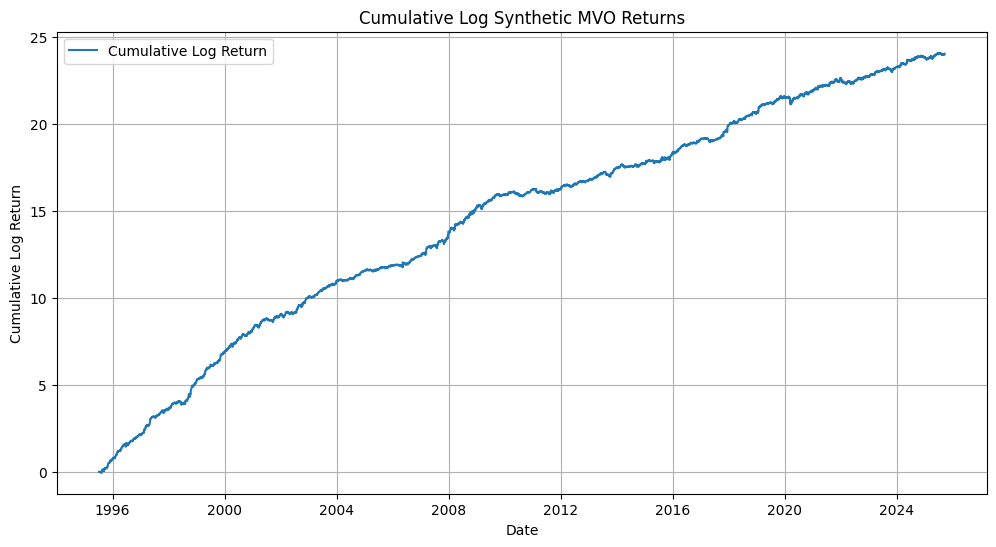

In [30]:
# Calculate cumulative returns
synMVO_cum_ret = ( 
    synMVO_ret.with_columns(
    pl.col('return').log1p().alias('log_return')
    )
    .with_columns(
    pl.col('log_return').cum_sum().alias('cum_log_return')
    )
)

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(synMVO_cum_ret["date"], synMVO_cum_ret["cum_log_return"], label="Cumulative Log Return")
plt.title("Cumulative Log Synthetic MVO Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Log Return")
plt.legend()
plt.grid(True)
plt.show()

In [31]:
def compute_sharpe_ratio(df: pl.DataFrame, return_col: str = "eqWtRet") -> float:
    """
    Compute annualized Sharpe ratio from daily portfolio returns.
    
    Args:
        df (pl.DataFrame): Must contain one row per date with a return column in decimal space.
        return_col (str): Column containing daily returns.
    
    Returns:
        float: Annualized Sharpe ratio.
    """
    # Extract daily returns
    daily_rets = df[return_col].to_numpy()

    mean_return = daily_rets.mean()
    std_return = daily_rets.std(ddof=1)

    # Annualized Sharpe (sqrt(252) for daily frequency)
    sharpe_annualized = (mean_return / std_return) * np.sqrt(252)

    return sharpe_annualized

In [32]:
compute_sharpe_ratio(synMVO_cum_ret, return_col='fwd_return')

np.float64(2.5645580926249716)

In [33]:
big_data = (
    big_data
    .with_columns(pl.col('momentum_weight').fill_null(0)
    )
    .with_columns(pl.col('meanrev_weight').fill_null(0)
    )
    .with_columns(pl.col('bab_weight').fill_null(0)
    )
)

big_data

date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-06-30,"""USAA191""",0.051471,-0.013986,0.823795,null,null,0.003645,0.0,0.0,-1.0844e-20
1995-06-30,"""USAA1W1""",0.057971,0.0,1.105022,null,null,-0.010093,0.0,0.0,-9.1201e-22
1995-06-30,"""USAA1Y1""",0.028777,-0.017483,1.636947,null,null,-0.027408,0.0,0.0,-4.8273e-21
1995-06-30,"""USAA2L1""",0.036585,0.002941,0.725292,null,null,0.010805,0.0,0.0,-4.2673e-21
1995-06-30,"""USAA311""",0.020134,-0.006579,0.798643,null,null,0.005402,0.0,0.0,-9.2198e-21
…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,0.0,-1.3553e-20,-6.9890e-22
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,0.0,-3.4045e-19,-3.7165e-21
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,0.0,-9.9263e-20,-2.6956e-21


In [34]:
# 1. Pivot meta-weights long → wide
meta_wide = (
    portfolio_data
    .pivot(values="weight", index="date", on="portfolio")
    .rename({"momentum": "momentum_mw", "meanrev": "meanrev_mw", "bab": "bab_mw"})
)

# 2. Join with asset-level table
combined = big_data.join(meta_wide, on="date", how="inner")

# 3. Compute portfolio weights
final_weights = combined.with_columns([
    (pl.col("momentum_weight") * pl.col("momentum_mw") +
     pl.col("meanrev_weight")  * pl.col("meanrev_mw")  +
     pl.col("bab_weight")      * pl.col("bab_mw")
    ).alias("total_weight")
])

final_weights


date,barrid,return,fwd_return,predicted_beta,momentum_alpha,meanrev_alpha,bab_alpha,momentum_weight,meanrev_weight,bab_weight,momentum_mw,meanrev_mw,bab_mw,total_weight
date,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1995-07-07,"""USAA191""",0.014286,-0.021127,0.804617,null,null,0.004024,0.0,0.0,-1.1946e-20,1.1104e-22,1.1104e-22,1.0,-1.1946e-20
1995-07-07,"""USAA1W1""",0.029412,0.0,1.087732,null,null,-0.008553,0.0,0.0,-4.9559e-22,1.1104e-22,1.1104e-22,1.0,-4.9559e-22
1995-07-07,"""USAA1Y1""",0.040816,0.008987,1.627489,null,null,-0.026459,0.0,0.0,-4.5260e-21,1.1104e-22,1.1104e-22,1.0,-4.5260e-21
1995-07-07,"""USAA2L1""",0.030675,-0.011905,0.633142,null,null,0.01479,0.0,0.0,-5.0982e-21,1.1104e-22,1.1104e-22,1.0,-5.0982e-21
1995-07-07,"""USAA311""",0.0,0.012346,0.840516,null,null,0.004094,0.0,0.0,-9.9570e-21,1.1104e-22,1.1104e-22,1.0,-9.9570e-21
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-09-15,"""USBQZR1""",-0.041651,null,1.365701,null,-0.159387,-0.024335,0.0,-1.3553e-20,-6.9890e-22,1.0,1.1102e-22,5.5519e-23,-1.5434e-42
2025-09-15,"""USBRGT1""",0.0,null,1.264243,null,0.012975,-0.005506,0.0,-3.4045e-19,-3.7165e-21,1.0,1.1102e-22,5.5519e-23,-3.8003e-41
2025-09-15,"""USBRH21""",0.011281,null,1.364664,null,-0.003457,-0.019368,0.0,-9.9263e-20,-2.6956e-21,1.0,1.1102e-22,5.5519e-23,-1.1170e-41


In [35]:
print(final_weights.group_by('date').agg(pl.col('total_weight').sum()))
print(final_weights['total_weight'].sum())
print(final_weights.select('date').unique().to_numpy().shape)

shape: (7_598, 2)
┌────────────┬──────────────┐
│ date       ┆ total_weight │
│ ---        ┆ ---          │
│ date       ┆ f64          │
╞════════════╪══════════════╡
│ 2017-09-26 ┆ 1.0          │
│ 2017-01-10 ┆ 1.0          │
│ 2010-03-16 ┆ 1.0          │
│ 2002-04-25 ┆ 1.0          │
│ 2006-08-14 ┆ 1.0          │
│ …          ┆ …            │
│ 2016-08-26 ┆ 1.0          │
│ 2011-12-28 ┆ 1.0          │
│ 2013-06-04 ┆ 1.0          │
│ 2023-02-09 ┆ 1.0          │
│ 2019-11-18 ┆ 1.0          │
└────────────┴──────────────┘
7597.999999708503
(7598, 1)


In [36]:
print(final_weights.group_by('date').agg(pl.col('barrid').n_unique()))

shape: (7_598, 2)
┌────────────┬────────┐
│ date       ┆ barrid │
│ ---        ┆ ---    │
│ date       ┆ u32    │
╞════════════╪════════╡
│ 2023-06-23 ┆ 2555   │
│ 2005-11-25 ┆ 2879   │
│ 2013-10-16 ┆ 2766   │
│ 2005-03-08 ┆ 2819   │
│ 2002-04-22 ┆ 2587   │
│ …          ┆ …      │
│ 2021-09-03 ┆ 2861   │
│ 2002-04-16 ┆ 2606   │
│ 2006-08-08 ┆ 2854   │
│ 2012-05-07 ┆ 2599   │
│ 2023-06-20 ┆ 2558   │
└────────────┴────────┘


In [37]:
final_weights = final_weights.select(['date', 'barrid', 'total_weight']).rename({'total_weight': 'weight'})
final_returns = sfp.generate_returns_from_weights(final_weights)

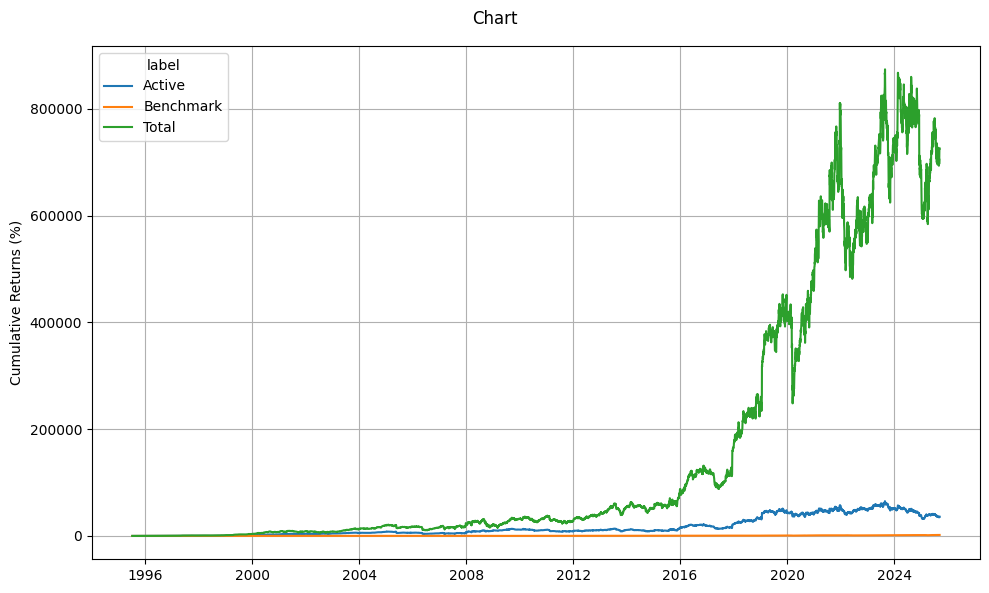

In [38]:
sfp.generate_returns_chart(final_returns, "Chart")

In [23]:
sfp.generate_summary_table(final_returns)

Portfolio,Count,Mean Return (%),Volatility (%),Total Return (%),Sharpe
str,u32,f64,f64,f64,f64
"""Active""",7600,23.29,27.5,36334.46,0.85
"""Benchmark""",7600,11.76,19.05,1904.89,0.62
"""Total""",7600,35.05,33.23,745469.39,1.05
